<a href="https://colab.research.google.com/github/RapoluUma956/AI_PCB_Defect_Detection_Classification_System/blob/main/DefectsClassification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing the standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import os
import random
import re
import shutil
sns.set_style('darkgrid')
sns.set_palette('pastel')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Defining the input
input_dir='/content/drive/MyDrive/PCB_DATASET'
os.listdir(input_dir)

['rotate.py',
 'images',
 'Defect_Patches',
 'PCB_USED',
 'rotation',
 'Annotations',
 'images_combined']

In [ ]:
template_dir=os.path.join(input_dir,'PCB_USED')
template_dir

'/content/drive/MyDrive/PCB_DATASET/PCB_USED'

In [ ]:
#Defining the image directory
img_dir=os.path.join(input_dir,'images')

#Listing the types of defects
os.listdir(img_dir)
types_defect=os.listdir(os.path.join(input_dir,'images'))
types_defect

['Missing_hole',
 'Mouse_bite',
 'Open_circuit',
 'Short',
 'Spur',
 'Spurious_copper']

In [ ]:
#Creating an image path list for ready refernce
img_path_list=[]
#Creating img_path list
for sub_cat in types_defect:
    sub_sub_cats = os.listdir(os.path.join(img_dir,sub_cat))
    for sub_sub_cat in sub_sub_cats:
        for file in os.listdir(os.path.join(img_dir,sub_cat,sub_sub_cat)):
            img_path_list.append(os.path.join(img_dir,sub_cat,sub_sub_cat,file))

In [ ]:
rotated_dir=os.path.join(input_dir,'rotation')
os.listdir(rotated_dir)

['Missing_hole_angles.txt',
 'Spur_angles.txt',
 'Mouse_bite_angles.txt',
 'Short_angles.txt',
 'Spurious_copper_angles.txt',
 'Open_circuit_angles.txt',
 'Short_rotation',
 'Mouse_bite_rotation',
 'Missing_hole_rotation',
 'Spurious_copper_rotation',
 'Open_circuit_rotation',
 'Spur_rotation']

In [ ]:
rotated_angle_list=[j for j in os.listdir(rotated_dir) if j.endswith('.txt')]
rotated_angle_list

['Missing_hole_angles.txt',
 'Spur_angles.txt',
 'Mouse_bite_angles.txt',
 'Short_angles.txt',
 'Spurious_copper_angles.txt',
 'Open_circuit_angles.txt']

In [ ]:
types_defect_rotated=[j for j in os.listdir(rotated_dir) if j.endswith('.txt')==False]
types_defect_rotated

['Short_rotation',
 'Mouse_bite_rotation',
 'Missing_hole_rotation',
 'Spurious_copper_rotation',
 'Open_circuit_rotation',
 'Spur_rotation']

In [ ]:
annote_dir=os.path.join(input_dir,'Annotations')
annote_dir

'/content/drive/MyDrive/PCB_DATASET/Annotations'

In [ ]:
type_annot=os.listdir(annote_dir)
type_annot

['Missing_hole',
 'Short',
 'Spurious_copper',
 'Spur',
 'Open_circuit',
 'Mouse_bite']

In [ ]:
#Checking the type of files
file_list=os.listdir(os.path.join(annote_dir,'Mouse_bite'))
file_list[0:5]

['08_mouse_bite_04.xml',
 '06_mouse_bite_04.xml',
 '06_mouse_bite_08.xml',
 '10_mouse_bite_05.xml',
 '12_mouse_bite_03.xml']

In [ ]:
#importing xml ET to parse xml file
import xml.etree.ElementTree as ET

In [ ]:
#Parsing XML to return Bounding box dimensions
def parse_xml(xml_file):

    data=[]

    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [ ]:
#Retrieving data for all files
data=[]
all_data=[]

for x in type_annot:
    for file in os.listdir(os.path.join(annote_dir,x)):
        xml_file_path=os.path.join(os.path.join(annote_dir,x),file)
        data=parse_xml(xml_file_path)
        all_data.extend(data)

In [ ]:
#Creating a dataframe to store the annotations
df_annot=pd.DataFrame(all_data)
df_annot

filename  width  height         class  xmin  ymin  xmax  \
0     09_missing_hole_03.jpg   2775    2159  missing_hole  1543   358  1612   
1     09_missing_hole_03.jpg   2775    2159  missing_hole  1897   646  1961   
2     09_missing_hole_03.jpg   2775    2159  missing_hole   563  1058   630   
3     09_missing_hole_03.jpg   2775    2159  missing_hole   199   638   276   
4     09_missing_hole_03.jpg   2775    2159  missing_hole  1833    97  1900   
...                      ...    ...     ...           ...   ...   ...   ...   
2948    01_mouse_bite_15.jpg   3034    1586    mouse_bite   601  1053   635   
2949    01_mouse_bite_15.jpg   3034    1586    mouse_bite  2651   558  2684   
2950    04_mouse_bite_05.jpg   3056    2464    mouse_bite   701   642   762   
2951    04_mouse_bite_05.jpg   3056    2464    mouse_bite  1106   621  1170   
2952    04_mouse_bite_05.jpg   3056    2464    mouse_bite  1595   473  1648   

      ymax  
0      422  
1      720  
2     1118  
3      704  
4      158  
...    ...  
2948  1084  
2949   591  
2950   724  
2951   688  
2952   551  

[2953 rows x 8 columns]

In [ ]:
# # Don't run this cell multiple times as it will create multiple copies of the images

# import os
# import shutil

# # Path to the main images folder (stored in img_dir)
# img_dir = "/content/drive/MyDrive/PCB_DATASET/images/"  # Path to your images folder

# # Define the source directories for each category inside img_dir
# source_dirs = [
#     os.path.join(img_dir, "Missing_hole"),
#     os.path.join(img_dir, "Mouse_bite"),
#     os.path.join(img_dir, "Open_circuit"),
#     os.path.join(img_dir, "Short"),
#     os.path.join(img_dir, "Spur"),
#     os.path.join(img_dir, "Spurious_copper")
# ]

# # Define the destination directory for the combined images (Writable location)
# destination_dir = "/content/drive/MyDrive/PCB_DATASET/images_combined/"

# # Create the destination directory if it doesn't exist
# os.makedirs(destination_dir, exist_ok=True)

# # Loop through each source directory and copy all files to the destination
# for source_dir in source_dirs:
#     if os.path.exists(source_dir):
#         # Get all files in the current directory
#         files = os.listdir(source_dir)

#         # Copy each file to the destination directory
#         for file in files:
#             file_path = os.path.join(source_dir, file)
#             if os.path.isfile(file_path):
#                 shutil.copy(file_path, destination_dir)
#     else:
#         print(f"Directory {source_dir} does not exist.")

# # Now check how many files are in the destination folder
# files_in_combined = os.listdir(destination_dir)
# print(f"Number of files copied: {len(files_in_combined)}")

Text(0.5, 0, 'No of defects in one PCB')

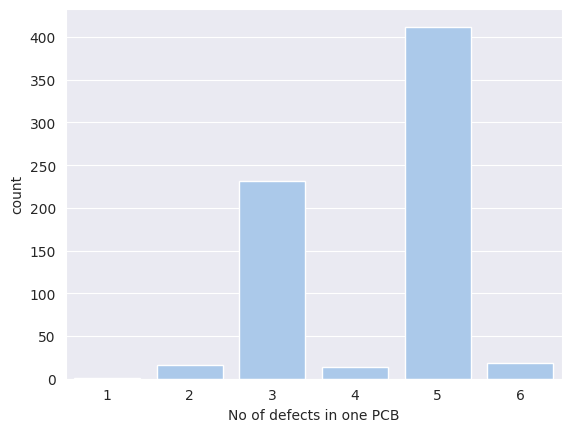

In [ ]:
#Visualizing the no of defects in each pcb
df_multiple_defects=pd.DataFrame(df_annot['filename'].value_counts())
sns.countplot(df_multiple_defects,x='count')
plt.xlabel('No of defects in one PCB')

In [ ]:
#Defining a function to view image along with bounding box

def draw_bounding_boxes(image_path, bounding_boxes,annotation):
    """
    Draws multiple bounding boxes on an image using Matplotlib.

    Args:
        image_path: The path to the image file.
        bounding_boxes: A list of bounding boxes, each represented as a tuple or list containing
                       (min_x, min_y, max_x, max_y).
    """

    # Load the image
    img = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15,10))

    # Display the image
    ax.imshow(img)

    # Draw each bounding box
    for bbox in bounding_boxes:
        min_x, min_y, max_x, max_y = bbox
        width = max_x - min_x
        height = max_y - min_y
        rect = patches.Rectangle((min_x, min_y), width, height, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Calculate the centroid of the bounding box
        centroid_x = (min_x + max_x) / 2
        centroid_y = (min_y + max_y) / 2

        # Add the annotation to the centroid
        ax.annotate( annotation,(centroid_x,centroid_y),(max_x+20,max_y+20),
            fontsize=10,color='white',
            horizontalalignment='right', verticalalignment='top')

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])



    # Show the plot
    plt.show()

In [ ]:
#Getting filename from filepath
filepath=img_path_list[0]
filename=re.sub(r'.+/([\w_]+\.jpg)',r'\1',filepath)


In [ ]:
filepath

'/content/drive/MyDrive/PCB_DATASET/images/Missing_hole/01_missing_hole/01_missing_hole_08.jpg'

In [ ]:
filename

'01_missing_hole_08.jpg'

In [ ]:
#Defining function to select the a file and return image along with bounding box
def visualize_annotations(list_image_path,df):
    for i in list_image_path:
        filepath=i
        filename=re.sub(r'.+/([\w_]+\.jpg)',r'\1',filepath)
        df_selected=df[df['filename']==filename]
        width=df_selected['width'].values
        height=df_selected['height'].values
        class_name=df_selected['class'].values
        xmin=df_selected['xmin'].values
        ymin=df_selected['ymin'].values
        xmax=df_selected['xmax'].values
        ymax=df_selected['ymax'].values

        bbox=zip(xmin,ymin,xmax,ymax)
        draw_bounding_boxes(filepath, bbox,class_name[0])

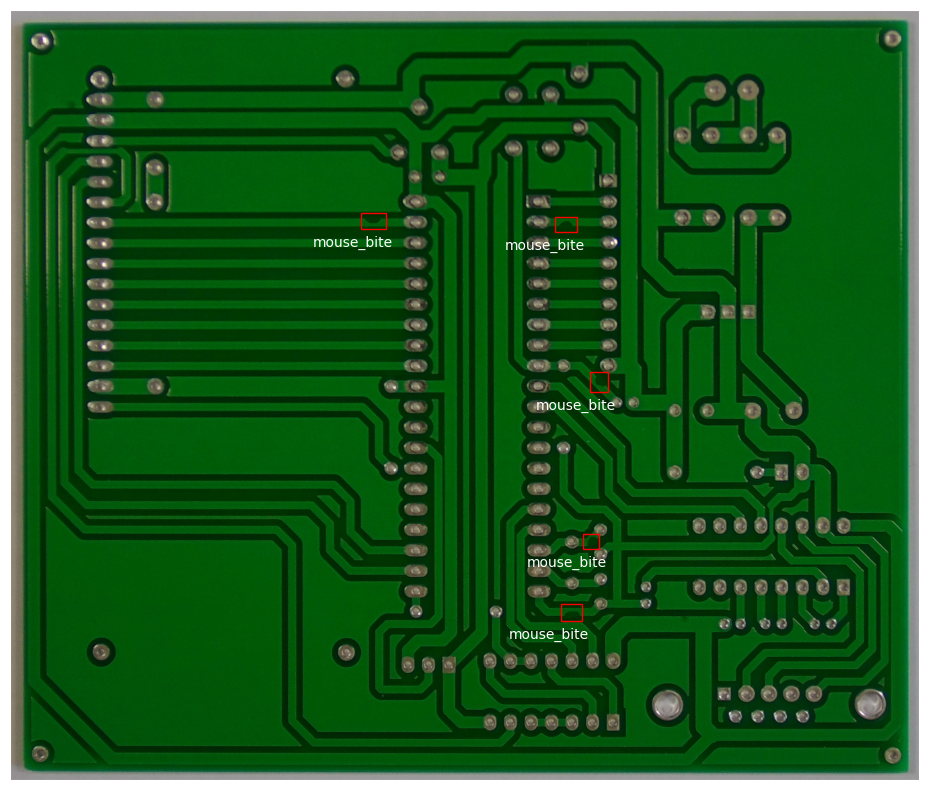

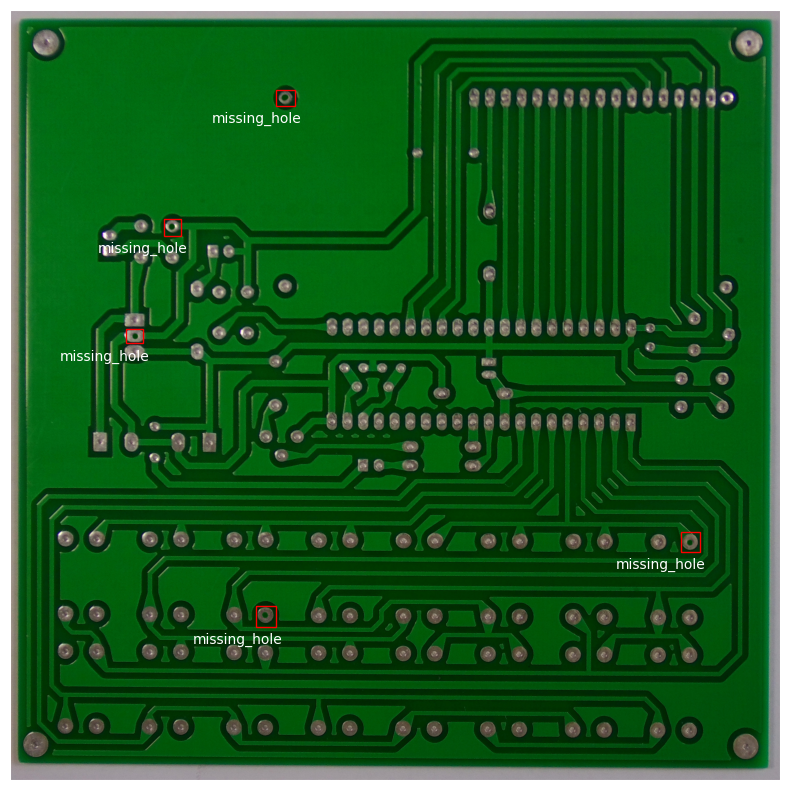

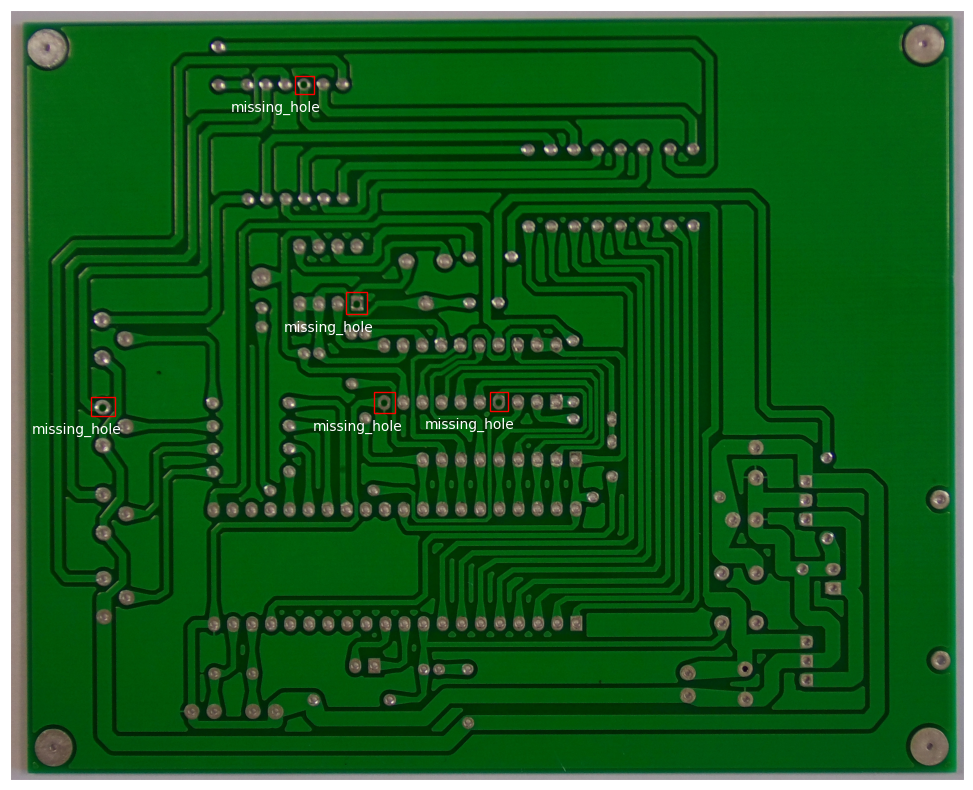

In [ ]:
random.shuffle(img_path_list)

visualize_annotations(img_path_list[0:3],df_annot)

In [ ]:
destination_dir = "/content/drive/MyDrive/PCB_DATASET/images_combined/"

PyTorch Version: 2.9.0+cpu
Using device: cpu
Preview of the provided annotation DataFrame:
                 filename  width  height    class_name  xmin  ymin  xmax  ymax
0  09_missing_hole_03.jpg   2775    2159  missing_hole  1543   358  1612   422
1  09_missing_hole_03.jpg   2775    2159  missing_hole  1897   646  1961   720
2  09_missing_hole_03.jpg   2775    2159  missing_hole   563  1058   630  1118
3  09_missing_hole_03.jpg   2775    2159  missing_hole   199   638   276   704
4  09_missing_hole_03.jpg   2775    2159  missing_hole  1833    97  1900   158

6 classes detected in the DataFrame: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']
Number of defects - Train: 2080, Validation: 442, Test: 431

Visualizing a batch of cropped defect patches...


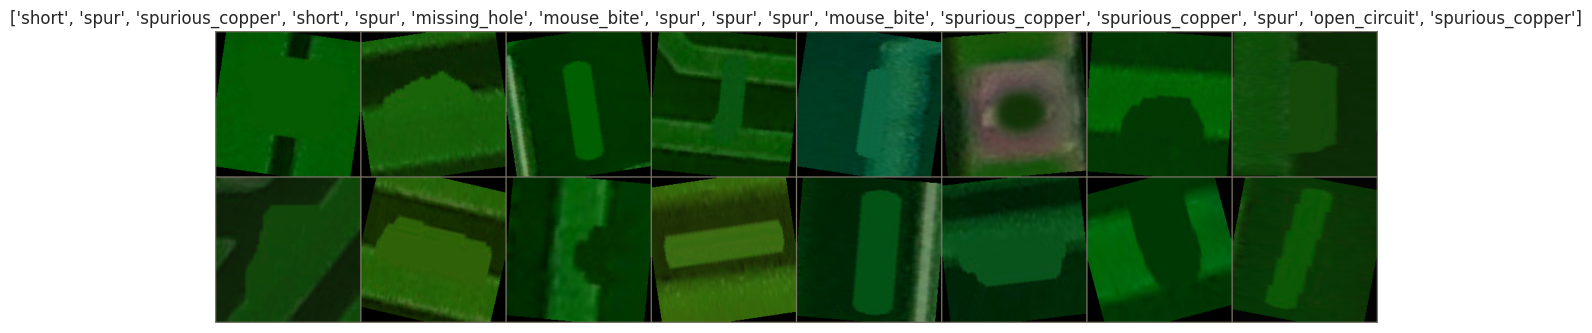

In [ ]:
# ===================================================================
# 1. IMPORTING LIBRARIES AND CONFIGURATION
# ===================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, utils

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time
import copy
import os

# Basic configuration
print("PyTorch Version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===================================================================
# 2. DATA PREPARATION (using df_annot and img_dir)
# ===================================================================
# ASSUMING 'df_annot' (DataFrame) AND 'img_dir' (str) ALREADY EXIST.

img_dir = destination_dir

# To avoid conflicts with the Python keyword 'class', rename the column
if 'class' in df_annot.columns:
    df_annot = df_annot.rename(columns={'class': 'class_name'})

print("Preview of the provided annotation DataFrame:")
print(df_annot.head())

# Get the list of classes and number of classes
class_names = sorted(df_annot['class_name'].unique())
num_classes = len(class_names)
print(f"\n{num_classes} classes detected in the DataFrame: {class_names}")

# --- Train/Validation/Test split based on FILE NAMES ---
# This is CRUCIAL to avoid data leakage.
unique_filenames = df_annot['filename'].unique()
# 693 images -> train_files : 485 , test_val_files : 208
train_files, test_val_files = train_test_split(unique_filenames, test_size=0.3, random_state=42)
# 208 -> val_files : 104 , test_files : 104
val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)  # 0.3 * 0.5 = 0.15


# Create DataFrames for each dataset
train_df = df_annot[df_annot['filename'].isin(train_files)].reset_index(drop=True)
val_df = df_annot[df_annot['filename'].isin(val_files)].reset_index(drop=True)
test_df = df_annot[df_annot['filename'].isin(test_files)].reset_index(drop=True)

dataset_sizes = {'train': len(train_df), 'val': len(val_df), 'test': len(test_df)}
print(f"Number of defects - Train: {dataset_sizes['train']}, Validation: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")

# --- Data Augmentation and Normalization ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Standardize patch size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Custom Dataset class for cropping images ---
class PCBCropDataset(Dataset):
    def __init__(self, dataframe, image_dir, class_names, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['filename']
        box = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
        label_idx = self.class_to_idx[row['class_name']]

        try:
            img_path = os.path.join(self.image_dir, img_filename)
            image = Image.open(img_path).convert('RGB')
            cropped_image = image.crop(box)
        except FileNotFoundError:
            print(f"Warning: File not found {img_path}. Returning an empty tensor.")
            return torch.zeros((3, 224, 224)), -1  # Handle missing file case

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, label_idx

# --- Create datasets and dataloaders ---
train_dataset = PCBCropDataset(train_df, img_dir, class_names, transform=data_transforms['train'])
val_dataset = PCBCropDataset(val_df, img_dir, class_names, transform=data_transforms['val'])
test_dataset = PCBCropDataset(test_df, img_dir, class_names, transform=data_transforms['val'])

# Use a smaller batch size initially to avoid memory issues
batch_size = 16

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
}

# --- Visualize a batch of cropped defect patches ---
print("\nVisualizing a batch of cropped defect patches...")
inputs, classes_idx = next(iter(dataloaders['train']))
out = utils.make_grid(inputs)

# Inverse normalization for display
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]); std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean; inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 8)); plt.imshow(inp)
    if title is not None: plt.title(title)
    plt.axis('off'); plt.show()

imshow(out, title=[class_names[x] for x in classes_idx])


In [ ]:
class_names

['missing_hole',
 'mouse_bite',
 'open_circuit',
 'short',
 'spur',
 'spurious_copper']

In [ ]:
# ===================================================================
# 3. PRETRAINED MODEL (ResNet18 - best performing approach)
# ===================================================================
def get_pretrained_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Freeze the weights of the pretrained layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer to adapt it to our problem
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model.to(device)



# ===================================================================
# 4. TRAINING AND VALIDATION FUNCTION
# ===================================================================
def train_model(model, criterion, optimizer, num_epochs=50, patience=5):
    since = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}' + ' | ' + '-'*10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward(); optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val':
                if epoch_loss < best_loss:
                    print(f"Validation loss improved ({best_loss:.4f} -> {epoch_loss:.4f}). Saving model...")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Validation Loss: {best_loss:4f}')

    model.load_state_dict(best_model_wts)
    return model, history



# ===================================================================
# 5. TRAINING EXECUTION
# ===================================================================
# Clear the GPU cache to ensure memory is free
if torch.cuda.is_available():
    # torch.cuda.empty_cache()
    pass

# Instantiate the model
resnet_model = get_pretrained_model(num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Optimize only parameters of the new layer (those that are not frozen)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001)

# Start training
best_resnet_model, history = train_model(resnet_model, criterion, optimizer, num_epochs=50, patience=5)



# ===================================================================
# 6. RESULT ANALYSIS AND EVALUATION
# ===================================================================
# --- Plot learning curves ---
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f"Learning curves for {model_name}", fontsize=16)
    ax1.plot(history['train_acc'], label='Train Acc'); ax1.plot(history['val_acc'], label='Val Acc')
    ax1.set_title('Accuracy'); ax1.set_xlabel('Epoch'); ax1.legend(); ax1.grid(True)
    ax2.plot(history['train_loss'], label='Train Loss'); ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_title('Loss'); ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(True)
    plt.show()

plot_history(history, "ResNet18 on cropped patches")

# --- Evaluation on the test set ---
def evaluate_model(model, dataloader, model_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\n--- Final evaluation of model '{model_name}' on the Test set ---\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predictions'); plt.ylabel('True Labels')
    plt.show()

evaluate_model(best_resnet_model, dataloaders['test'], "ResNet18")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Epoch 1/50 | ----------


KeyboardInterrupt: 

In [ ]:
# Path where you want to save
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/best_resnet18_pcb_defects_50epochs.pth"

# Save only the state_dict (recommended)
torch.save({
    "model_state_dict": best_resnet_model.state_dict(),
    "class_names": class_names,
}, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")

In [ ]:
# INFERENCE

In [ ]:
!pip install imagehash # Install missing library

In [ ]:
import os
import time
import numpy as np
import torch
from torchvision import models, transforms
from torchvision.ops import nms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import imagehash
from skimage.metrics import structural_similarity as ssim

print("--- Step 1: Differential detection pipeline configuration ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 1. LOAD CHECKPOINT (MODEL + CLASS NAMES)
# ===================================================================
model_path = "/content/drive/MyDrive/Colab Notebooks/best_resnet18_pcb_defects_50epochs.pth"

checkpoint = torch.load(model_path, map_location=device)
# checkpoint is a dict like: {"model_state_dict": ..., "class_names": ...}

# restore class names from checkpoint (preferred)
class_names = checkpoint.get("class_names", None)
if class_names is None:
    # fallback: manually define if not present
    class_names = ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']

if 'normal' in class_names:
    class_names.remove('normal')

num_classes = len(class_names)

# recreate architecture exactly as during training
defect_classifier = models.resnet18(weights=None)
in_features = defect_classifier.fc.in_features
defect_classifier.fc = torch.nn.Linear(in_features, num_classes)

# load ONLY the model_state_dict from checkpoint
defect_classifier.load_state_dict(checkpoint["model_state_dict"])

defect_classifier.to(device)
defect_classifier.eval()

# ===================================================================
# 2. CONFIG: GOLDEN IMAGES, WINDOW, NORMALIZATION
# ===================================================================
golden_images_dir = "/content/drive/MyDrive/PCB_DATASET/PCB_USED/"
if not os.path.exists(golden_images_dir):
    raise FileNotFoundError(f"Reference images directory '{golden_images_dir}' not found.")

WINDOW_SIZE = 128
STRIDE = WINDOW_SIZE // 4
SIMILARITY_THRESHOLD = 0.95
CLASSIFIER_CONFIDENCE_THRESHOLD = 0.80

# same normalization as training
inference_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ===================================================================
# 3. GOLDEN IMAGE DATABASE
# ===================================================================
def create_golden_image_database(golden_dir):
    db = []
    print("Creating reference image database...")
    filenames = os.listdir(golden_dir)
    for fname in filenames:
        path = os.path.join(golden_dir, fname)
        try:
            img = Image.open(path).convert('RGB')
            hash_val = imagehash.phash(img)
            db.append({'filename': fname, 'image': img, 'hash': hash_val})
        except Exception as e:
            print(f"Warning: Could not load '{path}'. Error: {e}")
    return db

golden_db = create_golden_image_database(golden_images_dir)
print(f"{len(golden_db)} reference images loaded successfully.")

# ===================================================================
# 4. DETECTION FUNCTIONS
# ===================================================================
def find_best_match(input_image, golden_database):
    if not golden_database:
        return None
    input_hash = imagehash.phash(input_image)
    best_match = min(golden_database, key=lambda x: input_hash - x['hash'])
    min_dist = input_hash - best_match['hash']
    print(f"Best match found: '{best_match['filename']}' (hash distance: {min_dist}).")
    if min_dist > 10:
        print("Warning: High hash distance, match may be incorrect.")
    return best_match['image']


def detect_anomalies_by_comparison(input_image, golden_image, classifier):
    if input_image.size != golden_image.size:
        raise ValueError("Input image and reference image must have the same dimensions!")

    detections = []
    start_time = time.time()

    img_width, img_height = input_image.size
    for y in range(0, img_height - WINDOW_SIZE + 1, STRIDE):
        for x in range(0, img_width - WINDOW_SIZE + 1, STRIDE):
            window_input = input_image.crop((x, y, x + WINDOW_SIZE, y + WINDOW_SIZE))
            window_golden = golden_image.crop((x, y, x + WINDOW_SIZE, y + WINDOW_SIZE))

            window_input_gray = np.array(window_input.convert('L'))
            window_golden_gray = np.array(window_golden.convert('L'))

            ssim_score, _ = ssim(window_golden_gray, window_input_gray, full=True)

            if ssim_score < SIMILARITY_THRESHOLD:
                patch_tensor = inference_transform(window_input).unsqueeze(0).to(device)
                with torch.no_grad():
                    outputs = classifier(patch_tensor)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    confidence, predicted_idx = torch.max(probabilities, 1)

                if confidence.item() > CLASSIFIER_CONFIDENCE_THRESHOLD:
                    detections.append({
                        'box': [x, y, x + WINDOW_SIZE, y + WINDOW_SIZE],
                        'label': class_names[predicted_idx.item()],
                        'confidence': confidence.item()
                    })

    print(f"Initial detection completed in {time.time() - start_time:.2f}s. {len(detections)} raw anomalies found.")

    if not detections:
        return []

    boxes = torch.tensor([d['box'] for d in detections], dtype=torch.float32)
    scores = torch.tensor([d['confidence'] for d in detections], dtype=torch.float32)
    keep_indices = nms(boxes, scores, iou_threshold=0.2)

    final_detections = [detections[i] for i in keep_indices]
    print(f"{len(final_detections)} final anomalies after Non-Max Suppression.")
    return final_detections


def draw_detections_on_image(image, detections):
    img_with_boxes = image.copy()
    draw = ImageDraw.Draw(img_with_boxes)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 32)
    except IOError:
        print("Font 'DejaVuSans.ttf' not found. Using default font (may be small).")
        font = ImageFont.load_default()

    unique_labels = list(set([d['label'] for d in detections]))
    colors = plt.cm.get_cmap('hsv', len(unique_labels) + 1)
    color_map = {
        label: tuple((np.array(colors(i)[:3]) * 255).astype(int))
        for i, label in enumerate(unique_labels)
    }

    for det in detections:
        box = det['box']
        label = det['label']
        confidence = det['confidence']

        color = color_map.get(label, (255, 50, 50))
        draw.rectangle(box, outline=color, width=5)

        text = f"{label} ({confidence:.2f})"

        try:
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
        except AttributeError:
            text_width, text_height = draw.textsize(text, font=font)

        background_box = [
            box[0],
            box[1] - text_height - 5,
            box[0] + text_width + 10,
            box[1]
        ]
        draw.rectangle(background_box, fill=color)
        draw.text((box[0] + 5, box[1] - text_height - 5),
                  text, fill="white", font=font)

    return img_with_boxes

# ===================================================================
# 5. RUN PIPELINE ON EXAMPLE IMAGE (STANDALONE)
# ===================================================================
test_image_path = "/content/drive/MyDrive/PCB_DATASET/images/Missing_hole/06_missing_hole/06_missing_hole_02.jpg"
test_image_name = os.path.basename(test_image_path)

print(f"\n--- Running pipeline on image: {test_image_name} ---")

try:
    input_image = Image.open(test_image_path).convert('RGB')

    golden_image_ref = find_best_match(input_image, golden_db)

    if golden_image_ref:
        anomalies = detect_anomalies_by_comparison(
            input_image,
            golden_image_ref,
            defect_classifier
        )

        result_image = draw_detections_on_image(input_image, anomalies)

        plt.figure(figsize=(20, 15))
        plt.imshow(result_image)
        plt.title(
            f"Detected Anomalies on '{test_image_name}' by Differential Comparison",
            fontsize=20
        )
        plt.axis('off')
        plt.show()
    else:
        print("No matching golden image found.")

except FileNotFoundError:
    print(f"ERROR: Test file '{test_image_path}' not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")